# 정규세션: Unsupervised Learing

## 1) 차원 축소 (Dimension Reduction)

In [2]:
# 메인 라이브러리 불러오기
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

# 시각화 관련 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

# 데이터 준비, 모델 평가 관련 라이브러리
from sklearn import preprocessing as ppp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# 알고리즘 관련 라이브러리 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [3]:
# MNIST data load

current_path = os.getcwd()
file = os.path.sep.join(['','mnist.pkl.gz'])

# 본인의 구글 드라이브(현재 디렉토리)에 mnist.pkl.gz 파일이 올라가 있어야 함!
# colab의 경우 content 폴더 바로 아래에 들어가면 됨

f = gzip.open(current_path+file, 'rb')

train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [5]:
# Pandas dataframe 생성하기
train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train) + len(X_validation))
test_index = range(len(X_train)+len(X_validation),
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

In [8]:
# 이미지 시각화
def view_digit(example):
    label = y_train.loc[example]
    image = X_train.loc[example,:].values.reshape([28, 28])
    plt.title('Example: %d     /     Label: %d'%(example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

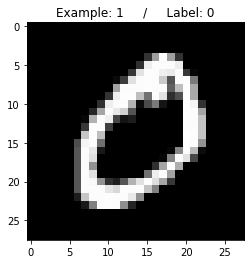

In [9]:
view_digit(319)

### 1-1) 주성분분석 (Principal Component Analysis, PCA)

주성분: 원래 feature / input variable들의 선형결합으로 만든 새로운 성분

만약 처음에 n개의 feature가 있었다면,<br>
PCA 과정에서 n개의 주성분을 얻어낼 수 있다.<br>
그리고 이 중에서 일부만을 추려서 사용하게 된다.

MNIST 데이터는 784차원이므로, 784개의 주성분을 얻을 수 있고 그 중의 일부만을 골라서 사용하게 된다.<br>
(값이 큰 Eigenvalue에 상응하는 주성분부터 선별하게 된다.)

사실, PCA는 **data covariance matrix를 고유값분해(Eigendecomposition)**하는 것과 같고<br>
그때 계산되는 **고유벡터가 주성분**(Principal Component)이 된다.

- data covariance matrix: $\frac{1}{N}\Sigma XX^{T}$ = 항상 Square matrix -> Eigendecomposition 가능!

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 784)

In [11]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [17]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:, 0:1], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis=1, join='inner')
    tempDF.columns = ["1st Vector", "2nd Vector", "Label"]
    sns.lmplot(x="1st Vector", y="2nd Vector", hue="Label",
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Seperation of Observations using "+algoName)

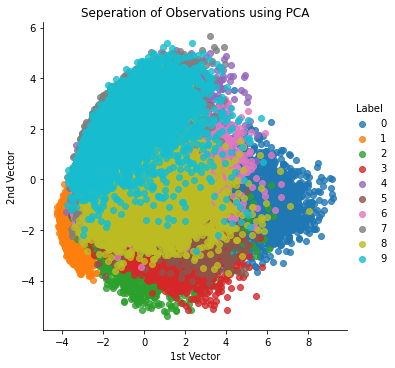

In [18]:
scatterPlot(X_train_PCA, y_train, "PCA")

#### 1-1-1) 점진적 PCA

Incremental PCA: 데이터셋의 크기가 매우 커서 메모리에 저장할 수 없는 경우에 사용하기 적합한 방식

메모리에 저장되는 크기로 배치를 작게 설정해, PCA를 점진적으로 수행하는 것.
(보통 일반 PCA와 그 결과는 유사함)

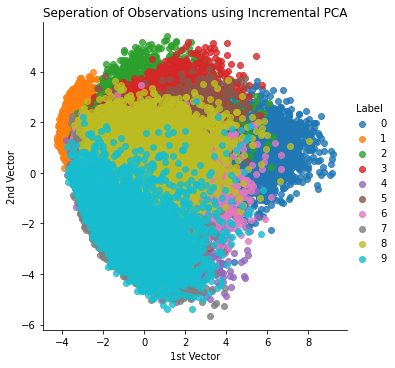

In [19]:
# 점진적 PCA
from sklearn.decomposition import IncrementalPCA

n_components = 784
batch_size = None

incrementalPCA = IncrementalPCA(n_components = n_components,
                                batch_size = batch_size)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA,
                                      index=train_index)
X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = pd.DataFrame(data=X_validation_incrementalPCA,
                                           index=validation_index)

scatterPlot(X_train_incrementalPCA, y_train, "Incremental PCA")

#### 1-1-2) 희소 PCA

희소(Sparce): Data Point 간의 거리가 멀리 떨어져 있는 상태<br>
주로 피처의 개수가 많은, 즉 고차원의 Data에서 자주 발생함.

희소 PCA에서는, 데이터의 희소성을 어느 정도 유지하면서 PCA를 시행한다.<br>
일부 입력변수에서만 선형 결합을 탐색하는 원리로, 피처 공간을 줄이지만 일반 PCA만큼 조밀해지지는 않는다고 한다.

* 일반 PCA: 하나의 주성분이 원래의 **모든** 독립변수의 선형결합으로 이루어짐

* 희소 PCA: 하나의 주성분이 원래의 **일부** 독립변수의 선형결합으로 이루어짐

특히, ***데이터의 개수(n)가 독립변수의 개수(p)보다 적은 경우***에도 사용할 수 있다는 것이 장점이다!

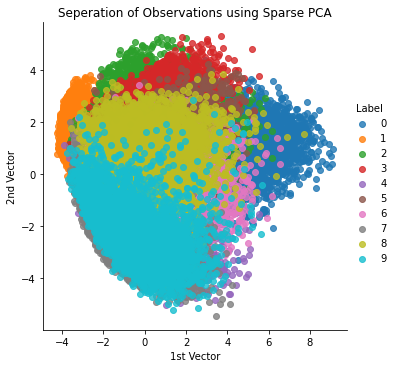

In [20]:
from sklearn.decomposition import SparsePCA

n_components = 100
alpha = 0.0001
n_jobs = -1            # -1: Use all processors

sparsePCA = SparsePCA(n_components=n_components,
                      alpha = alpha,
                      n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:10000, :])   # 학습 속도가 느려서 10000개만 사용
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA,
                                 index=train_index)
X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = pd.DataFrame(data=X_validation_sparsePCA,
                                      index=validation_index)
scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

#### 1-1-3) 커널 PCA
일반 PCA와 희소 PCA는 여전히 원래 독립변수의 선형결합으로 주성분을 만들기 때문에, <br>선형 관계만을 잡아낼 수 있다는 약점이 있다.

커널 트릭(Kernel Trick)을 이용해서, 비선형 PCA를 시행하는 기법이다.

* Kernel Trick: 특정 선형 벡터의 내적을 이용해, 비선형 벡터의 값을 계산해 내는 방식

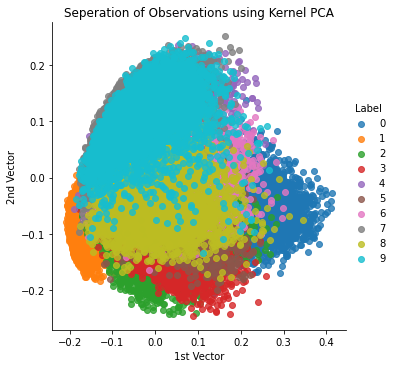

In [21]:
# Kernel PCA

from sklearn.decomposition import KernelPCA

n_components = 100
kernel = 'rbf'

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel)
kernelPCA.fit(X_train.loc[:10000, :])

X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data = X_train_kernelPCA,
                                 index=train_index)

X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = pd.DataFrame(data = X_validation_kernelPCA,
                                      index=validation_index)

scatterPlot(X_train_kernelPCA, y_train, 'Kernel PCA')

### 1-2) 특잇값 분해 (SVD)
앞서 본 $A = U \Sigma V^{T}$ 에서, $\Sigma$ 의 차원을 의도적으로 낮추는 방법.

원래 $\Sigma$ 가 $ N \times m $ 행렬 (N차원 자료가 m개)이었는데 2차원으로 축소하고 싶다면<br>
$\Sigma$의 좌측 상단 $ 2 \times 2 $ 행렬만 사용하는 것.

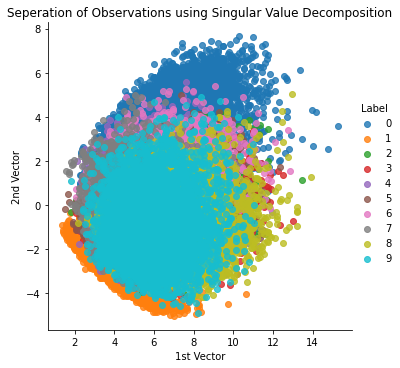

In [22]:
# SVD
from sklearn.decomposition import TruncatedSVD

n_components = 200
algorithm = 'randomized'
n_iter = 5

svd = TruncatedSVD(n_components = n_components,
                   algorithm = algorithm,
                   n_iter = n_iter)

X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)

X_validation_svd = svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation_svd,
                                index=validation_index)

scatterPlot(X_train_svd, y_train, 'Singular Value Decomposition')

### 1-3) 랜덤 투영 (Random Projection, RP)
Johnson-Lindenstrauss Lemma를 이론적 근거로 하는 선형 차원 축소 기법.<br>
* J-L Lemma: $ 0 < \epsilon < 1$ 일 때, $N$차원으로 표현된 점 $m$개가 있다면, 다음 조건식을 만족시키는 linear map $ f : ℝ^{N} \rightarrow ℝ^{n} $ 이 존재한다. 단, $ n > 8 \times \frac{ln(m)}{\epsilon^{2}} $.<br>
    - $ (1-\epsilon) ||u-v||^{2} \le ||f(u)-f(v)||^{2} \le (1+\epsilon) ||u-v||^{2}$

의미] 데이터 간의 거리를 **거의 그대로 보존하면서 데이터의 차원을 줄이는 것이 가능**하다!

https://lovit.github.io/machine%20learning/vector%20indexing/2018/03/28/lsh/

https://en.wikipedia.org/wiki/Low-rank_approximation

#### 1-3-1) 가우시안 랜덤 투영 (Gaussian Random Projection, GRP)

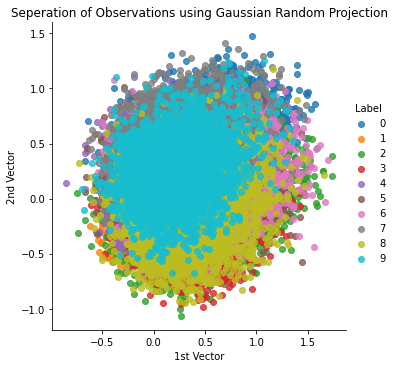

In [23]:
# GRP
from sklearn.random_projection import GaussianRandomProjection

n_components = 'auto'
eps = 0.5              # J-L lemma의 epsilon (축소할 차원인 n에 영향을 미침)

GRP = GaussianRandomProjection(n_components = n_components,
                               eps = eps)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=train_index)

X_validation_GRP = GRP.transform(X_validation)
X_validation_GRP = pd.DataFrame(data=X_validation_GRP, index=validation_index)

scatterPlot(X_train_GRP, y_train, 'Gaussian Random Projection')

#### 1-3-2) 희소 랜덤 투영 (Sparse Random Projection, SRP)

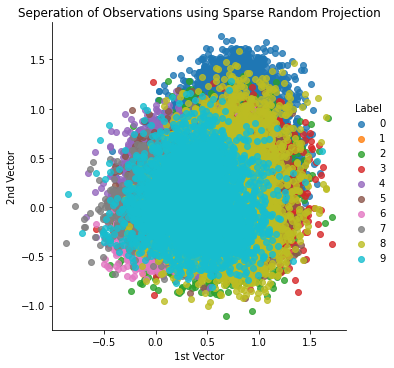

In [24]:
# SRP
from sklearn.random_projection import SparseRandomProjection

n_components = 'auto'
density = 'auto'
eps = 0.5

SRP = SparseRandomProjection(n_components = n_components,
                             density = density, eps=eps,
                             dense_output = False)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=train_index)

X_validation_SRP = SRP.transform(X_validation)
X_validation_SRP = pd.DataFrame(data=X_validation_SRP, index=validation_index)

scatterPlot(X_train_SRP, y_train, 'Sparse Random Projection')

### 1-4) 아이소맵 (Isometric Mapping, IsoMap)

앞서 살펴본 PCA, SVD, RP는 모두 선형 차원 축소 방법이었다.<br>
이번에 살펴볼 Isomap은 대표적인 **비선형** 차원 축소 방법으로, **매니폴드 학습**의 일종이다.<br>
(kernel PCA의 확장판이라고 볼 수 있다고 합니다)


* **매니폴드**(Manifold): 국소적으로 유클리드 공간과 닮았으나 전체적으로는 그렇지 않은 위상 공간 <br>  = **"꽤 복잡한 모양"**의 위상 공간

즉, Isomap은 매니폴드 공간에서 각 포인트들과 이웃하는 포인트들 사이의<br>
상대적인 위치를 기반으로 원본 데이터의 **고유한 기하학적 구조를 학습**합니다.

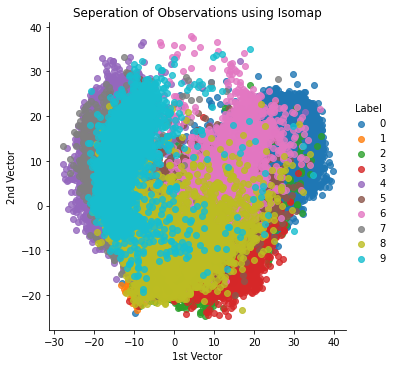

In [25]:
# Isomap
from sklearn.manifold import Isomap

isomap = Isomap(n_neighbors = 5,           # Number of neighbors to consider for each point
                n_components = 10,         # Number of coordinates for the manifold.
                n_jobs = 4)                # The number of parallel jobs to run.

isomap.fit(X_train.loc[0:5000, :])          # 학습 속도가 다른 선형 기법들보다 느려서 5000개만 사용
X_train_isomap = isomap.transform(X_train)
X_train_isomap = pd.DataFrame(data=X_train_isomap, index=train_index)

X_validation_isomap = isomap.transform(X_validation)
X_validation_isomap = pd.DataFrame(data=X_validation_isomap, index=validation_index)

scatterPlot(X_train_isomap, y_train, 'Isomap')

Isomap 외에도 다양한 비선형 차원축소 기법이 존재합니다.<br>
(다차원 스케일링(MDS), 지역 선형 임베딩(LLE), t분포 확률적 임베딩(t-SNE) 등)

지금까지 차원 축소 기법을 살펴 보았습니다.

차원 축소는 데이터셋에서 가장 핵심적인 정보를 <br>
낮은 차원의 데이터셋으로 포착합니다. (without labels)

위의 예시는 모두 784차원의 데이터를 **2차원으로** 시각화한 결과임을 감안한다면 <br>
차원 축소는 꽤 강력한 기법임을 짐작할 수 있을 것입니다.

## 2) 군집화 (Clustering)

In [26]:
# PCA (차원 축소 후 군집화 적용하기 위해 준비하는 단계)

from sklearn.decomposition import PCA

pca = PCA(n_components = 784)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

### 2-1) k-평균 군집화 (k-means Clustering)

In [27]:
# k-means clustering
from sklearn.cluster import KMeans

kMeans_inertia = pd.DataFrame(data=[], index=range(2, 21), columns=['inertia'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, tol=0.0001,
                    max_iter=300)
    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:, 0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

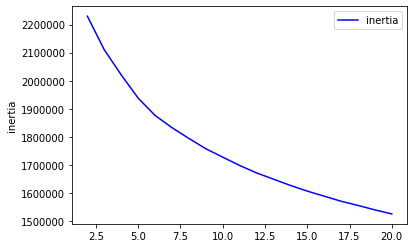

In [28]:
plt.ticklabel_format(style='plain', axis='y')
sns.lineplot(x=range(2, 21),
             y=kMeans_inertia.iloc[:, 0], color='blue', label='inertia')

군집의 수($k$)가 늘어날 수록, 관성(=군집 내의 분산)이 작아진다는 것을 볼 수 있습니다.<br>
이는 곧 군집이 균일해졌다는 것을 의미하고, 군집화가 성공적으로 이루어진다는 의미이기도 합니다.

하지만 군집이 늘어날 수록 연산량이 늘어나기 때문에,<br>
**관성과 연산량은 서로 trade-off 관계**에 있습니다.

In [29]:
# clustering 정확도 계산

def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster,left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [30]:
n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21),columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=range(2,21),columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, 
                    max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, 
                                           index=X_train.index,columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

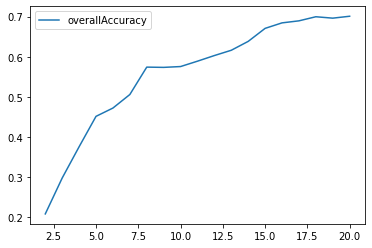

In [31]:
overallAccuracy_kMeansDF.plot()

### 2-2) 계층적 군집화 (Hierarchical Clustering)

계층적 군집화는 군집의 **개수를 사용자가 미리 설정하지 않아도** 사용할 수 있는 군집화 기법입니다.<br>
**덴드로그램(Dendrogram)**을 이용하기 때문에 이러한 방식이 실현 가능합니다.

#### 2-2-1) Dendrogram

https://online.visual-paradigm.com/diagrams/templates/dendrogram/cluster-dendrogram/

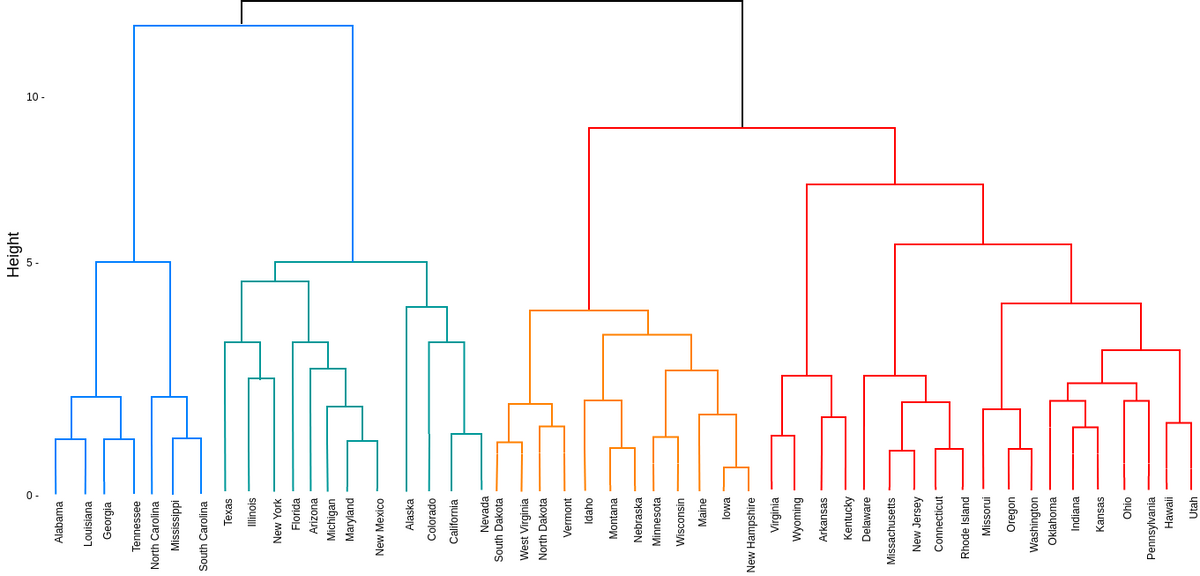

덴드로그램: 데이터들이 서로 얼마나 유사한지를 뒤집힌 트리 형태로 표현한 그림<br>
유사할수록 낮은 높이에서 합쳐지고,<br>
성격이 다를수록 높은 높이에서 합쳐집니다.

계층적 군집화에서는 데이터를 덴드로그램으로 표현한 후,<br>
**어느 높이에서 트리를 잘라낼 것인지**에 따라 군집 수를 결정합니다!

더 높은 높이에서 자를수록 군집 수가 적어지고,<br>
더 낮은 높이에서 자를수록 군집 수는 많아집니다.

https://seongjuhong.com/2020-03-14pm-hierarchical-clustering/

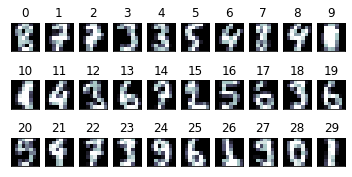

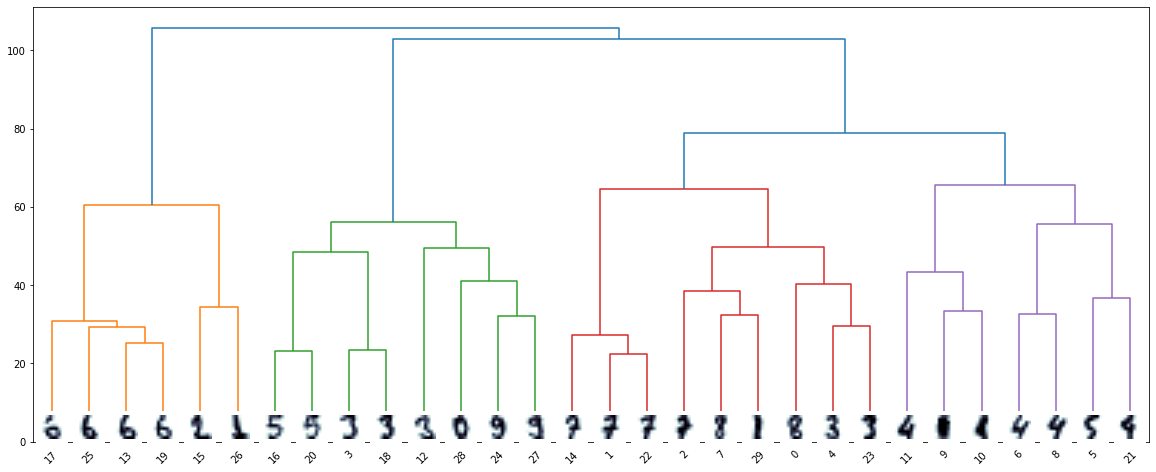

In [38]:
from sklearn.datasets import load_digits
from scipy.cluster.hierarchy import dendrogram, linkage

digits = load_digits()
n_image = 30
np.random.seed(0)
idx = np.random.choice(range(len(digits.images)), n_image)
X_image = digits.data[idx]
images = digits.images[idx]

plt.figure(figsize=(6, 3))
for i in range(n_image):
    plt.subplot(3, 10, i + 1)
    plt.imshow(images[i], cmap=plt.cm.bone)
    plt.grid(False)
    plt.xticks(())
    plt.yticks(())
    plt.title(i)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure(figsize=(20, 8))
ax = plt.subplot()

# Hierarchical Clustering
import fastcluster
Z = fastcluster.linkage_vector(X_image, method='ward', metric='euclidean')
ddata = dendrogram(Z)  

dcoord = np.array(ddata["dcoord"])
icoord = np.array(ddata["icoord"])
leaves = np.array(ddata["leaves"])
idx = np.argsort(dcoord[:, 2])
dcoord = dcoord[idx, :]
icoord = icoord[idx, :]
idx = np.argsort(Z[:, :2].ravel())
label_pos = icoord[:, 1:3].ravel()[idx][:n_image]

for i in range(n_image):
    imagebox = OffsetImage(images[i], cmap=plt.cm.bone_r, interpolation="bilinear", zoom=3)
    ab = AnnotationBbox(imagebox, (label_pos[i], 0),  box_alignment=(0.5, -0.1), 
                        bboxprops={"edgecolor" : "none"})
    ax.add_artist(ab)

plt.show()

#### 2-2-2) fastcluster.linkage_vector

fastcluster.linkage_vector를 사용할 때에는 method와 metric을 설정해 줘야 합니다.<br>
metric은 주로 'euclidean'을 사용하면 된다고 합니다<br>
(특히 후술할 method가 'centroid', 'median', 'ward'라면 반드시 metric='euclidean'이어야 합니다.)

method는 군집(cluster)와 개체 간, 혹은 군집과 군집 간의 거리를 구할 때,<br>
거리를 구하는 방식을 규정해 주는 부분입니다.

* single: 군집 A와 군집 B의 element들 중 가장 가까운 것들 사이의 거리
* centroid: 군집 A와 군집 B의 두 centroid 사이의 거리
* median: 군집 A와 군집 B의 두 median 사이의 거리
* ward: Ward's minimum variance method 적용 (추천!)

https://cran.r-project.org/web/packages/fastcluster/vignettes/fastcluster.pdf